# Testing repeatability of distance between clusters in a UMAP space


In this script, we compute multiple UMAP representations of a fixed dataset of digits (0, 2-9).

We don't change any parameters for UMAP generation, except the seed for the random generator.

Then, we compute the pairwise distances b/w the clusters of a given pair of digits, across the multiple UMAP representations.

For distance b/w clusters, the centroid of the cluster is computed as the geometric mean.

MNIST dataset:- https://en.wikipedia.org/wiki/MNIST_database

[LeCun et al., 1998a]
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998. [on-line version] 

#### Auxilliary set up

In [1]:
# Import packages
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
import umap
import hdbscan
from scipy.spatial import distance
from scipy.stats import gmean, mode
import sklearn.cluster as cluster
from tqdm import tqdm

/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from io import BytesIO
from PIL import Image
import base64

In [3]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10


from bokeh.models import ColorBar
# from bokeh.transform import linear_cmap

output_notebook()

Loading BokehJS ...

In [4]:
#### Auxilliary functions

In [5]:
def calc_gm(cluster):
    """ Caclulate the geometric mean of a cluster. """
    center_x = gmean(cluster[:,0])
    center_y = gmean(cluster[:,1])

    return np.array([center_x, center_y])

In [6]:
def collect_cluster(cluster_no):
    """ Collect all points in a cluster. """
    indices = np.where(labels == cluster_no)
    cluster_points = embedding[indices]

    return cluster_points


In [7]:
def calc_distance(cluster1, cluster2):
    """ Calculate the euclidean distance between two clusters. """

    center1 = cluster_gmeans[cluster1]
    center2 = cluster_gmeans[cluster2]

    euc_dist = distance.euclidean(center1, center2)
    
    return euc_dist

In [8]:
def switch_labels(orig_labels, mnist):
    """
        Switch the labels of the clusters to the most common label in the cluster.

        Explanation:
        Normally, the clusters are labelled randomly. This function matches the label of a cluster to the digit it represents.
        It also makes all the labels in a cluster the same (= the most common label in the cluster).

    """
    new_labels = np.zeros((orig_labels.shape))
    
    # The manually assigned labels (ground-truth)
    targets = mnist['target']

    sublabel = 1

    for k in np.arange(n_clusters):
        # Collect all the labels in a given cluster
        ind = np.where(orig_labels==k)
        # Find the ground truth label for the cluster
        t = mnist['target'][ind]
        # Find the mode of the ground truth labels in the cluster (to be sure which digit this cluster represents)
        cluster_mode = mode(t).mode

        # 2 clusters represent the same digit 1. In this case, we label one cluster as 1 and the other as 10.
        ## I have removed the digit 1 from the dataset, so this is not necessary anymore.
        ### The + 1000 is just a placeholder while swapping the labels. Can be done in a more readable manner.
        if cluster_mode==1:
            new_label = sublabel + 1000
            sublabel = 10
        else:
            new_label = cluster_mode + 1000
        # Switch to the new label
        new_labels[ind] = new_label

    return new_labels - 1000



#### Setting the dataset up

In [9]:
### Load MNIST dataset of handwritten digits
 
mnist = load_digits()
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [10]:
# Filter out the digit 1 from the mnist dataset and create a new dataset mnist2
mnist2 = {}
mnist2['data'] = mnist['data'][(mnist['target'] != 1)]
mnist2['target'] = mnist['target'][(mnist['target'] != 1)]
mnist2['frame'] = mnist['frame']
mnist2['feature_names'] = mnist['feature_names']
mnist2['target_names'] = mnist['target_names'][(mnist['target_names'] != 1)]
mnist2['images'] = mnist['images'][(mnist['target'] != 1)]
mnist2['DESCR'] = mnist['DESCR']


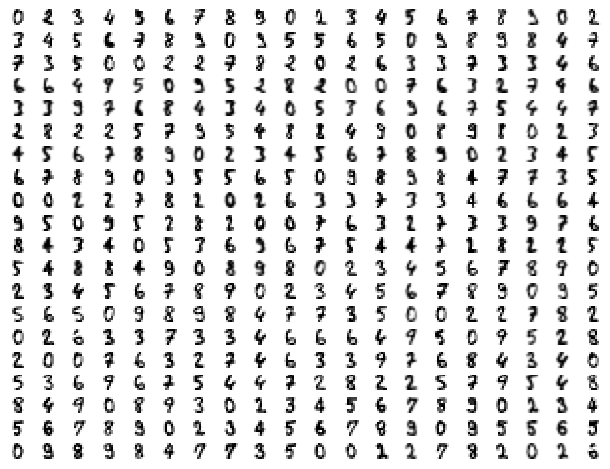

In [11]:
#  Visualize a subset of the data
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(mnist2['images'][i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

#### We generate multiple UMAP representations of the digits dataset

In [12]:
# Initialising a global seed for the random number generator
np.random.seed(0)

In [13]:
# Set up the path for saving the results
results_path = 'Figures/wo1_digits/no_exclusion/'

# Describing the included digits
digits = [0, 2, 3, 4, 5, 6, 7, 8, 9]
n_digits = len(digits)

# Set the number of iterations and number of clusters expected (= # of digits) 
n_iterations = 10
n_clusters  = n_digits

# Initialising a matrix to hold all the pairwise distances in each representation
distance_matrix = np.zeros((n_clusters, n_clusters, n_iterations))
distance_dict = {
    'digit1': [],
    'digit2': [],
    'iteration': [],
    'distance': []
}

In [14]:
### Ignore this old script for clustering using HDBSCAN

## Testing hdbscan vs kmeans. Decided to stick to kmeans as we can control the number of clusters and associate them with the og labels. 

# labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=20).fit_predict(embedding)
# labels = cluster.KMeans(n_clusters=n_clusters).fit_predict(embedding)

# new_labels = labels

# print(labels.min(), labels.max())

# # Make a plot of the UMAP embedding and clusters
# fig = plt.figure()
# plt.scatter(embedding[:, 0], embedding[:, 1], c=new_labels, cmap='tab20', s=1, alpha=.5)

# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(new_labels.max()+2)-0.5).set_ticks(np.arange(new_labels.max()+1))



In [15]:
# Run the dimension reducion and clustering n_iterations times
for n_iter in tqdm(np.arange(n_iterations)):
    print('iteration #: ', n_iter)

    # Make one UMAP embedding of the data
    rseed = np.random.randint(0,1e9)
    reducer = umap.UMAP(random_state=rseed)
    reducer.fit(mnist2['data'])
    embedding = reducer.transform(mnist2['data'])

    # Normalise the embedding such that all the low D coordinates are in the range [0,1]
    ## (Verify: Will normalising be an issue by altering pairwise distances?)
    embedding = (embedding-embedding.min())
    embedding = embedding/embedding.max()

    # Store the generated low D embedding
    mnist2['embedding'] = np.array(embedding)

    # Cluster the low D embedding
    labels = cluster.KMeans(n_clusters=n_clusters).fit_predict(embedding)
    # labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(embedding) # In case we want to use HDBSCAN

    # Cleaning
    ## Matching the generated labels to the digit it represents
    new_labels = switch_labels(labels, mnist2)

    # Store the generated cluster labels
    mnist2['cluster'] = np.array(new_labels)

    # Find the centroid = geometric mean of each cluster
    cluster_gmeans  = np.zeros((n_clusters, 2))
    for nc in np.arange(n_clusters):
        cluster_points = collect_cluster(nc)
        cluster_gmeans[nc] = calc_gm(cluster_points)

    # Make a plot of the UMAP embedding and clusters
    fig = plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=new_labels, cmap='tab20', s=1, alpha=.5)

    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(new_labels.max()+2)-0.5).set_ticks(np.arange(new_labels.max()+1))

    plt.scatter(cluster_gmeans[:,0], cluster_gmeans[:,1], c='black', s=10, marker='x')

    plt.title('UMAP projection of the Digits dataset', fontsize=14)


    plt.savefig(results_path + 'UMAP_' + str(n_iter) + '.png')

    plt.close()

    # Find distance between all pairs of clusters
    for cluster1 in np.arange(n_clusters):
        for cluster2 in np.arange(n_clusters):
            if cluster1 < cluster2:
                # Calculate the euclidean distance between a given pair of clusters
                dist = calc_distance(cluster1, cluster2)
                
                # Store the pairwise distance in the distance matrix
                distance_matrix[cluster1, cluster2, n_iter] = dist
                # distance_matrix[cluster2, cluster1, n_iter] = 0
                distance_dict['digit1'].append(digits[cluster1])
                distance_dict['digit2'].append(digits[cluster2])
                distance_dict['iteration'].append(n_iter)
                distance_dict['distance'].append(dist)






  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  0


 10%|█         | 1/10 [00:10<01:34, 10.49s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  1


 20%|██        | 2/10 [00:15<00:58,  7.31s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  2


 30%|███       | 3/10 [00:20<00:44,  6.34s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  3


 40%|████      | 4/10 [00:25<00:33,  5.66s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  4


 50%|█████     | 5/10 [00:30<00:27,  5.49s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  5


 60%|██████    | 6/10 [00:36<00:22,  5.51s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  6


 70%|███████   | 7/10 [00:41<00:16,  5.45s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  7


 80%|████████  | 8/10 [00:46<00:10,  5.37s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  8


 90%|█████████ | 9/10 [00:51<00:05,  5.21s/it]/opt/anaconda3/envs/umap-proof/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


iteration #:  9


100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


In [16]:
# Save the distance matrix in an npy file
np.save(results_path + 'distance_matrix.npy', distance_matrix)

# Store the distance matrix in a csv file
distance_df = pd.DataFrame.from_dict(distance_dict)
distance_df.to_csv(results_path + 'distance_dataframe.csv', index=True)  


#### Let's look at a sample UMAP to visualise the digits in each cluster with an interactive plot.

In [17]:
## Script for an interactive plot of a sample UMAP embedding.
# It uses the ground truth labels.
# Unverified code.  !!


# Define a function to convert the MNIST images to a format suitable for embedding in the hover tooltips
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

# Create a DataFrame for the embedding and add the images
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['digit'] = [str(x) for x in mnist2['target']]
digits_df['image'] = list(map(embeddable_image, mnist2['images']))

# Create a ColumnDataSource from the DataFrame
datasource = ColumnDataSource(digits_df)

# Create a color mapper
color_mapping = CategoricalColorMapper(factors=[str(x) for x in np.unique(mnist2['target'])], palette=Spectral10)

# Create the figure
plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    width=600,
    height=600,
    tools=('pan, wheel_zoom, reset')
)

# Add the hover tool
hover = HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
""")
plot_figure.add_tools(hover)

# Add the scatter plot
plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)

# Add a color bar
color_bar = ColorBar(color_mapper=color_mapping, width=8, location=(0,0))
plot_figure.add_layout(color_bar, 'right')

# Show the plot
show(plot_figure)

### Analyses

#### Plotting the pairwise distance b/w a given pair across the several iteratiions

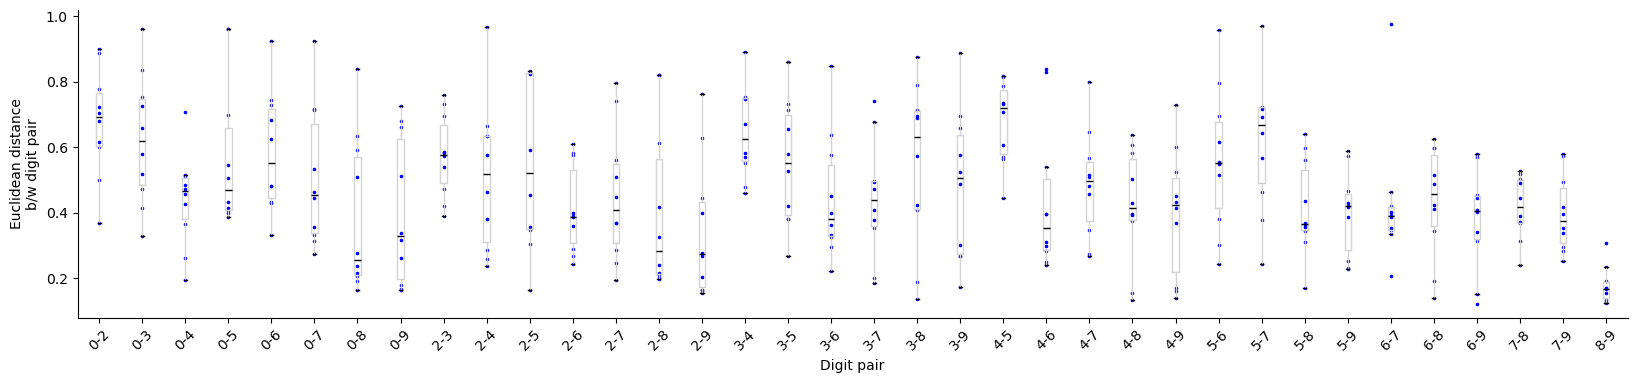

In [18]:
# Plot distances from all iterations for each pair of digit clusters
fig, ax = plt.subplots(1, figsize=(20, 4))
x_ticklabels = []

# Iterating through all pairs of digits
k = 0
for i in np.arange(n_clusters):
    for j in np.arange(n_clusters):
        if i<j:
            # Make a box plot
            ax.boxplot(distance_matrix[i, j],
                   patch_artist=False,  # fill with color
                   positions = [k],
                   boxprops=dict(color='lightgrey'),
                   whiskerprops=dict(color='lightgrey'),
                   showfliers = False,
                   medianprops = dict(color='black')
                   ) 
            # Indicate each data point
            ax.scatter(np.zeros((n_iterations))+k, distance_matrix[i, j], s=10, color='blue', marker='.')

            # Add the x-tick labels
            tl = str(digits[i]) + '-' + str(digits[j])
            x_ticklabels.append(tl)

            # Increment the position on the x axis
            k += 1

# Plot formatting
ax.set_xticklabels(x_ticklabels, rotation=45);
ax.set_ylabel('Euclidean distance\nb/w digit pair')
ax.set_xlabel('Digit pair')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)



Fig: The x axis indicates the pair of digits being tested. The blue point shows the euclidean distance b/w the clusters of the test pair, in one UMAP representation. The box plot describes the distribution of pairwise distances for a given test pair.

In [19]:
# Saving the figure
fig.savefig(results_path + 'pairwise_cluster_distances_kmlabel.png', bbox_inches='tight')